<a href="https://colab.research.google.com/github/Landonishere/PatternFlow/blob/topic-recognition/recognition/s45650938/YOLOv3_s456093.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a YOLOv3 Object Detector with Darknet in the Cloud! 

Cloning and Building Darknet

In [11]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

#Download pretrained YOLOv3 weights
YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [13]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-10-29 04:35:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  21.1MB/s    in 12s     

2021-10-29 04:35:54 (19.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [12]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

### Connect to Google Drive
Upload image to google drive

In [14]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists
'Colab Notebooks'		     'My Drive'
 darknet			      yolo3
 ISIC2018_Task1-2_Training_Input_x2   yolov3
 keras_png_slices_data		      yolov3_custom3_last.weights（副本）


# Training a Custom YOLOv3 Object Detector in the Cloud!



# Step 2: Moving Your Custom Dataset Into Your Cloud VM
So now that you have your dataset properly formatted to be used for training we need to move it into this cloud VM so that when it comes the time we can actually use it for training.

I recommend renaming the folder with your images and text files on your local machine to be called '**obj**' and then creating a .zip folder of the 'obj' folder. Then I recommend uploading the zip to your Google Drive. So you should now have obj.zip someplace in your Google drive. 

This will **greatly reduce** the time it takes to transfer our dataset into our cloud VM.

Now we can copy in the zip and unzip it on your cloud VM.

In [24]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive

'Colab Notebooks'		     'My Drive'
 darknet			      yolo3
 ISIC2018_Task1-2_Training_Input_x2   yolov3
 keras_png_slices_data		      yolov3_custom3_last.weights（副本）


In [25]:
# copy the train.zip file into the root directory of cloud VM
!cp /mydrive/yolov3/obj.zip ../

In [27]:
# copy the test.zip file into the root directory of cloud VM
!cp /mydrive/yolov3/test.zip /content/darknet/data

In [22]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip /content/gdrive/MyDrive/yolov3/obj.zip -d data/

Archive:  /content/gdrive/MyDrive/yolov3/obj.zip
   creating: data/obj/
  inflating: data/obj/ISIC_0000000.jpg  
  inflating: data/obj/ISIC_0000000.txt  
  inflating: data/obj/ISIC_0000001.jpg  
  inflating: data/obj/ISIC_0000001.txt  
  inflating: data/obj/ISIC_0000003.jpg  
  inflating: data/obj/ISIC_0000003.txt  
  inflating: data/obj/ISIC_0000004.jpg  
  inflating: data/obj/ISIC_0000004.txt  
  inflating: data/obj/ISIC_0000006.jpg  
  inflating: data/obj/ISIC_0000006.txt  
  inflating: data/obj/ISIC_0000007.jpg  
  inflating: data/obj/ISIC_0000007.txt  
  inflating: data/obj/ISIC_0000008.jpg  
  inflating: data/obj/ISIC_0000008.txt  
  inflating: data/obj/ISIC_0000009.jpg  
  inflating: data/obj/ISIC_0000009.txt  
  inflating: data/obj/ISIC_0000011.jpg  
  inflating: data/obj/ISIC_0000011.txt  
  inflating: data/obj/ISIC_0000012.jpg  
  inflating: data/obj/ISIC_0000012.txt  
  inflating: data/obj/ISIC_0000013.jpg  
  inflating: data/obj/ISIC_0000013.txt  
  inflating: data/obj/ISIC

In [28]:
# unzip the test.zip file and its contents should now be in /darknet/data/obj
!unzip /content/darknet/data/test.zip -d data/

Archive:  /content/darknet/data/test.zip
   creating: data/test/
  inflating: data/test/ISIC_0011151.jpg  
  inflating: data/test/ISIC_0011155.jpg  
  inflating: data/test/ISIC_0011156.jpg  
  inflating: data/test/ISIC_0011157.jpg  
  inflating: data/test/ISIC_0011158.jpg  
  inflating: data/test/ISIC_0011159.jpg  
  inflating: data/test/ISIC_0011161.jpg  
  inflating: data/test/ISIC_0011162.jpg  
  inflating: data/test/ISIC_0011163.jpg  
  inflating: data/test/ISIC_0011164.jpg  
  inflating: data/test/ISIC_0011165.jpg  
  inflating: data/test/ISIC_0011166.jpg  
  inflating: data/test/ISIC_0011167.jpg  
  inflating: data/test/ISIC_0011168.jpg  
  inflating: data/test/ISIC_0011169.jpg  
  inflating: data/test/ISIC_0011170.jpg  
  inflating: data/test/ISIC_0011171.jpg  
  inflating: data/test/ISIC_0011173.jpg  
  inflating: data/test/ISIC_0011176.jpg  
  inflating: data/test/ISIC_0011177.jpg  
  inflating: data/test/ISIC_0011199.jpg  
  inflating: data/test/ISIC_0011202.jpg  
  inflating

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.

I have a detailed video on how to properly configure all four of these files to train a custom yolov3 detector. I will spare the time and ask you to watch the video in order to properly learn how to prepare the files.

You can access the video with this link! [Configuring YOLOv3 Files for Training](https://www.youtube.com/watch?v=zJDUhGL26iU&t=300s)

## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

In [ ]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom2.cfg

In [ ]:
# to download to local machine (change its name to yolov3_custom.cfg once you download)
download('cfg/yolov3.cfg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** I set my **max_batches = 4000**, **steps = 3200, 3600**, I changed the **classes = 1** in the three YOLO layers and **filters = (classes+5)*3=18** in the three convolutional layers before the YOLO layers. 



In [29]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov3/yolov3_custom3.cfg ./cfg

# upload the custom .cfg back to cloud VM from local machine (uncomment to use)
#%cd cfg
#upload()
#%cd .. 

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

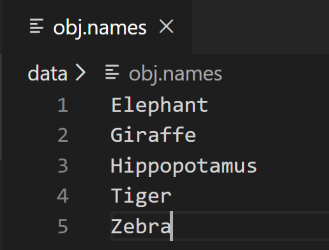

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

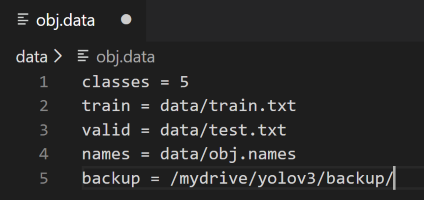



In [30]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov3/obj.data ./data
!cp /content/gdrive/MyDrive/yolov3/obj.name  ./data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

Luckily I have created a script that I showed in a past video that generates train.txt for us.

The script can be accessed from this [Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)

Just download the file to your local machine or Google drive so we can upload it to your cloud VM.

In [32]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov3/generate_train.py ./



In [34]:
# upload the generate_test.py script to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov3/generate_test.py ./

Now we simply run the python script to do all the work for us.

In [35]:
!python generate_train.py

In [36]:
!python generate_test.py

In [37]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  train.txt
coco9k.map  goal.txt		      obj		scream.jpg  voc.names
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.name		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	test.zip


If everything went as planned double click on **train.txt** on the left side File Explorer and it should look like this.
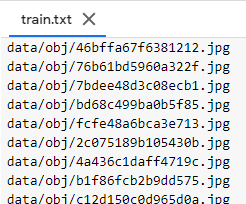

It will contain one line for each training image path.

# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. USE IT!

In [38]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2021-10-29 05:51:11--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  20.9MB/s    in 8.2s    

2021-10-29 05:51:20 (18.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Step 5: Train Your Custom Object Detector!
The time has finally come! You have made it to the moment of truth! You are now ready to train your custom YOLOv3 object detector on whatever crazy classes you have decided on. So run the following command. (dont_show flag stops a chart from popping up since cloud can't open images on the spot)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!

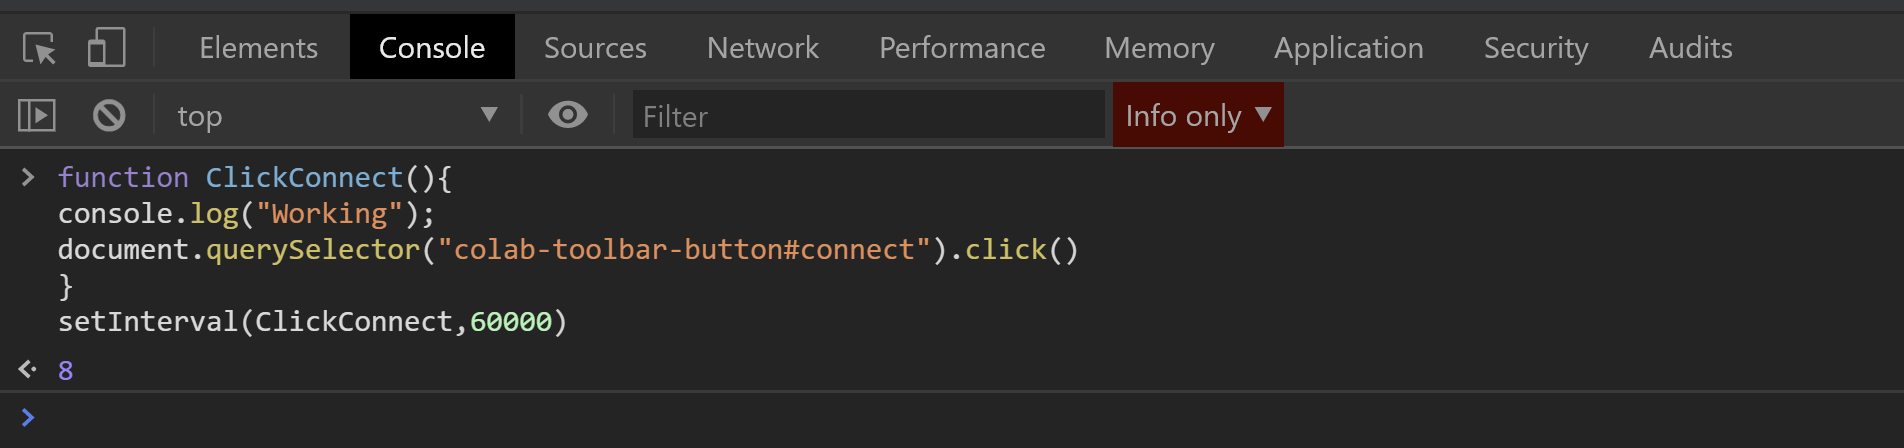

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom3.cfg darknet53.conv.74 -dont_show

流式输出内容被截断，只能显示最后 5000 行内容。
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.894188), count: 3, class_loss = 0.191398, iou_loss = 0.035805, total_loss = 0.227202 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.011501, iou_loss = 0.034620, total_loss = 0.046121 
 total_bbox = 527454, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.615624), count: 1, class_loss = 0.047477, iou_loss = 0.073460, total_loss = 0.120937 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.777457), count: 1, class_loss = 0.002042, iou_loss = 0.058969, total_loss = 0.061011 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 

You can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you would aim for a loss under 2.

In [ ]:
imShow('chart.png')

NameError: ignored

**TRICK**: If for some reason you get an error or your Colab goes idle during training, you have not lost your weights! Every 100 iterations a weights file called **yolov3_custom_last.weights** is saved to **mydrive/yolov3/backup/** folder (wherever your backup folder is). This is why we created this folder in our Google drive and not on the cloud VM. If your runtime crashes and your backup folder was in your cloud VM you would lose your weights and your training progress.

We can kick off training from our last saved weights file so that we don't have to restart! WOOHOO! Just run the following command but with your backup location.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

# Step 6: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

In [39]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom3.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom3.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

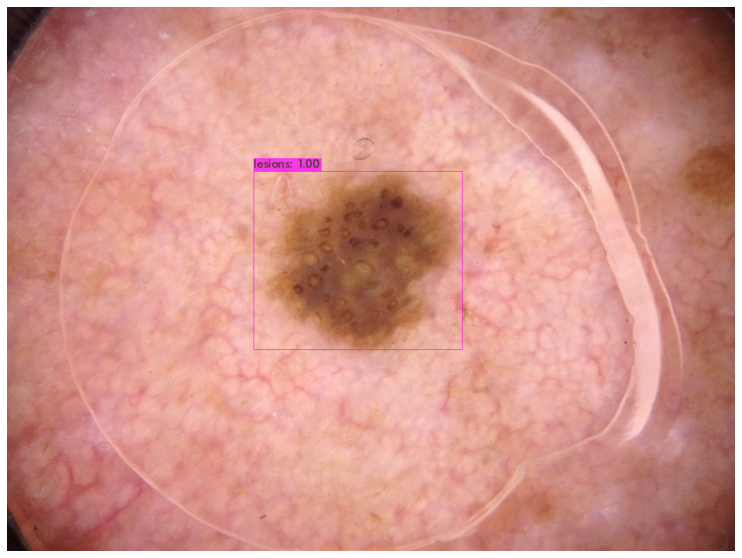

In [40]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /content/gdrive/MyDrive/yolov3/backup/yolov3_custom3_last.weights /content/gdrive/MyDrive/yolov3/a1.jpg -thresh 0.8
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

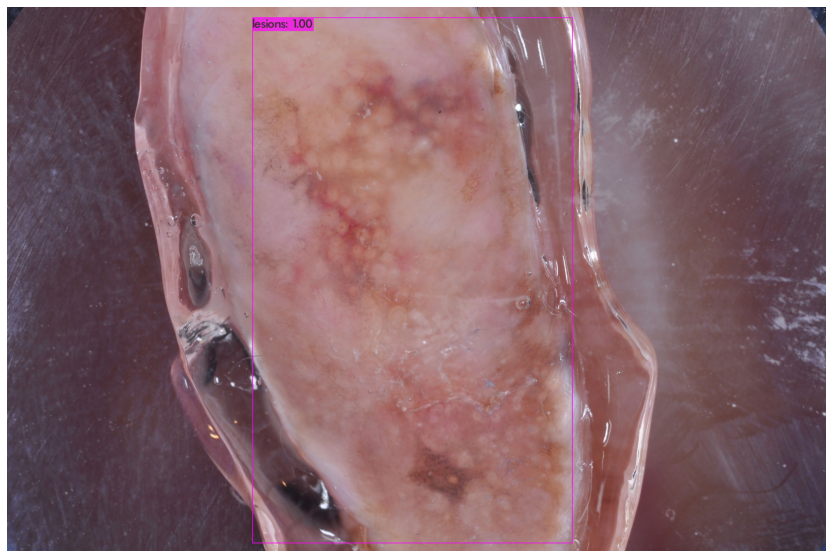

In [41]:
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights /content/gdrive/MyDrive/yolov3/a2.jpg -thresh 0.8
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

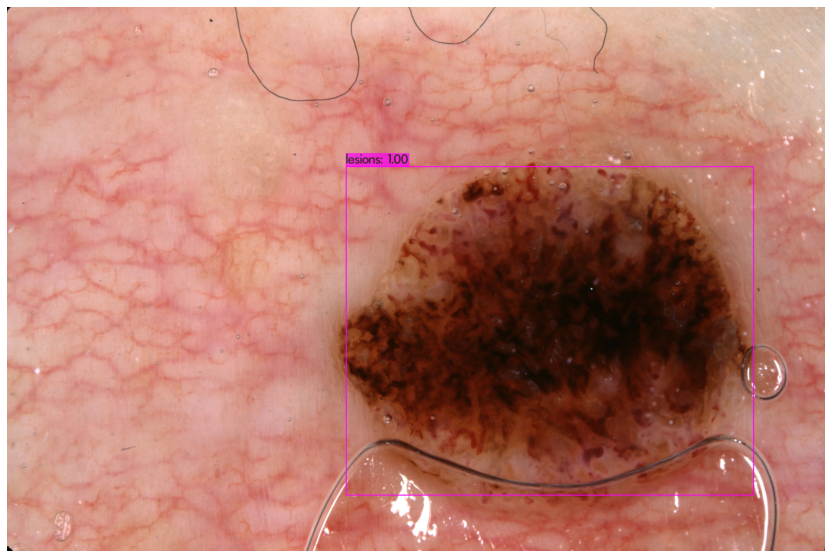

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights /content/darknet/data/obj/ISIC_0015032.jpg -thresh 0.8
imShow('predictions.jpg')

In [ ]:
!cp /content/darknet/results/comp4_det_test_lesions.txt /content/gdrive/MyDrive/yolov3

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

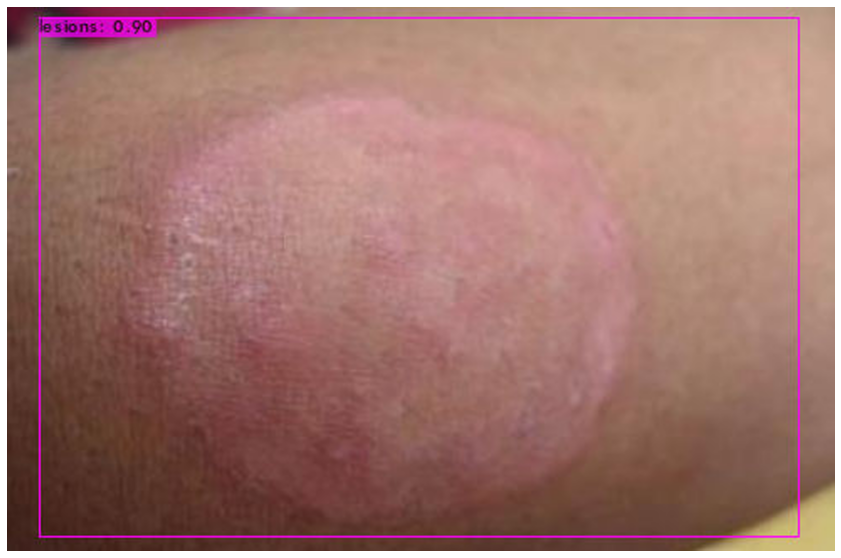

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights /content/gdrive/MyDrive/yolov3/test3.jpg -thresh 0.8
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

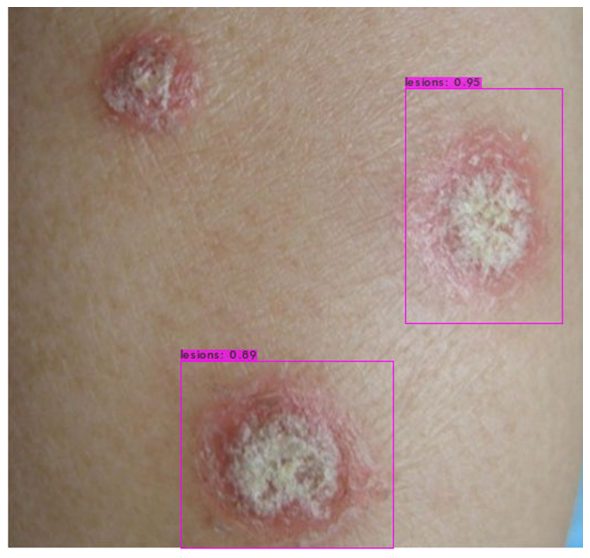

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights /content/gdrive/MyDrive/yolov3/test4.jpg -thresh 0.8
imShow('predictions.jpg')

In [ ]:
!./darknet detector test data/obj.data  cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -dont_show -ext_output /content/gdrive/MyDrive/yolov3/train.txt /content/gdrive/MyDrive/yolov3/result.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Couldn't open file: data/obj.data  cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -dont_show -ext_output /content/gdrive/MyDrive/yolov3/train.txt /content/gdrive/MyDrive/yolov3/result.txt


In [ ]:
!cp /content/gdrive/MyDrive/yolov3/result.txt /content/darknet

In [ ]:

!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -dont_show -ext_output <data/train.txt> result.txt

/bin/bash: ./darknet detector test data/obj.data: No such file or directory


In [ ]:
# Use calc_mAP.cmd to test the mean average precision
!./darknet detector map data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -points 11

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

In [ ]:
!./darknet detector recall data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -points 11

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

In [ ]:
#YOLOv3计算mAP教程

/content


# Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!

If you enjoy YOLOv3 check out my other videos and subscribe to my channel so you don't miss out on any other amazing YOLOv3 content! 

[The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)